In [151]:
import rockhound as rh
import numpy as np
import matplotlib.pyplot as plt

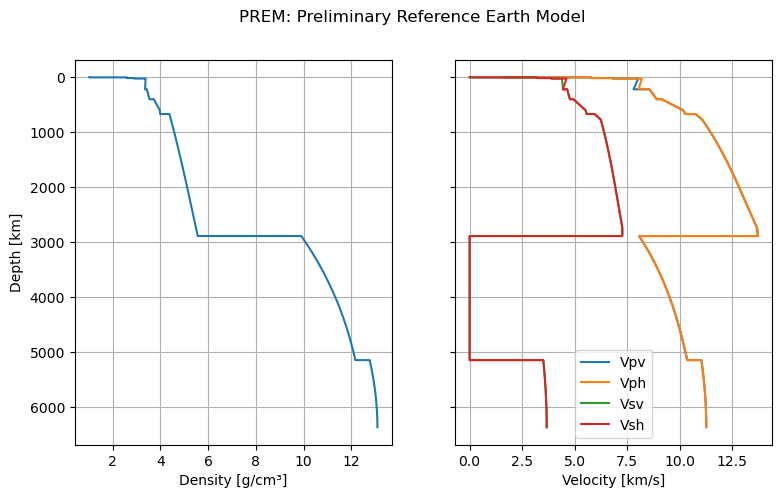

In [152]:
# Load PREM into a DataFrame
prem = rh.fetch_prem()
# print(prem)
# Plot density and velocities
fig, axes = plt.subplots(1, 2, figsize=(9, 5), sharey=True)
fig.suptitle("PREM: Preliminary Reference Earth Model")
ax = axes[0]
prem.plot("density", "depth", legend=False, ax=ax)
ax.invert_yaxis()
ax.set_xlabel("Density [g/cm³]")
ax.set_ylabel("Depth [km]")
ax.grid()
ax = axes[1]
for velocity in ["Vpv", "Vph", "Vsv", "Vsh"]:
    prem.plot(velocity, "depth", legend=False, ax=ax, label=velocity)
ax.grid()
ax.legend()
ax.set_xlabel("Velocity [km/s]")
plt.show()

In [153]:
import pygimli as pg
import pygimli.meshtools as mt

(<Axes: >, None)

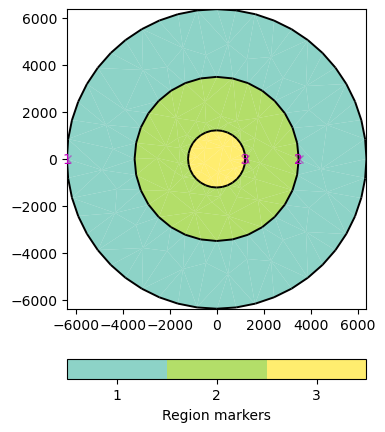

In [154]:
earth = mt.createCircle(radius=6.371e3, nSegments=48, marker=1)
earth.scale([-1, 1])
outercore = mt.createCircle(radius=3.49e3, nSegments=32, marker=2)
innercore = mt.createCircle(radius=1.216e3, nSegments=32, marker=3)
geo = earth+outercore+innercore
pg.show(geo)

(<Axes: >, None)

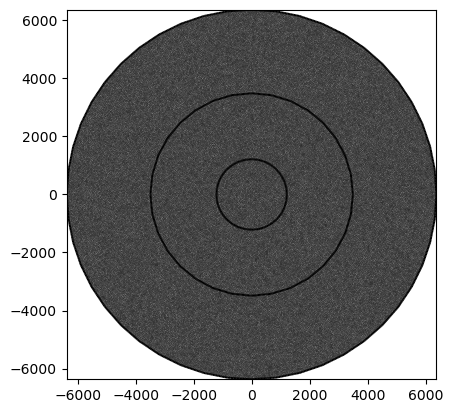

In [155]:
mesh = mt.createMesh(geo, area=1e3)
pg.show(mesh)

(<Axes: >, <matplotlib.colorbar.Colorbar at 0x1fe1bcf9370>)

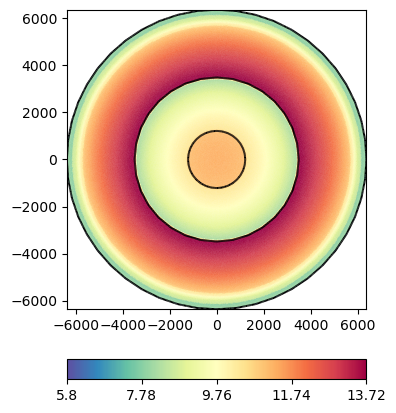

In [156]:
from scipy.interpolate import interp1d
cc = mesh.cellCenters()
rn = np.sqrt(pg.x(cc)**2+pg.y(cc)**2)
ii = np.argsort(rn)
v = np.zeros_like(rn)
# v[ii] = np.interp(rn[ii], rad, prem["Vpv"], "nearest")
f = interp1d(prem["radius"], prem["Vpv"])
v = f(rn)
pg.show(mesh, v, cMap="Spectral_r")

In [157]:
from pygimli.physics import traveltime as tt
data = tt.DataContainer()
for n in earth.nodes():
    data.createSensor(n.pos())

data.resize(data.sensorCount()//2)
data["s"] = np.zeros(data.size())
data["g"] = np.arange(data.size()) + 1
print(data)

Data: Sensors: 48 data: 24, nonzero entries: ['g', 's']


In [158]:
fop = tt.TravelTimeModelling(secNodes=5)
fop.setData(data)
fop.setMesh(mesh)

In [ ]:
data["t"] = fop.response(1/v/1000)

24/11/23 - 10:12:39 - pyGIMLi - INFO - Creating forward mesh from region infos.
24/11/23 - 10:12:41 - pyGIMLi - INFO - Creating refined mesh (secnodes: 5) to solve forward task.


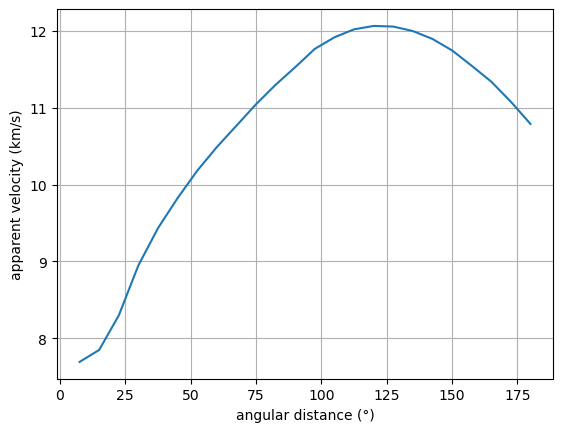

In [ ]:
dist = tt.shotReceiverDistances(data)
# print(dist)
va = dist / data["t"]
ang = data["g"] / data.sensorCount() * 360
plt.plot(ang, va/1000)
plt.xlabel("angular distance (°)")
plt.ylabel("apparent velocity (km/s)")
plt.grid()

24/11/23 - 11:00:35 - pyGIMLi - INFO - Creating forward mesh from region infos.
24/11/23 - 11:00:35 - pyGIMLi - INFO - Creating refined mesh (secnodes: 3) to solve forward task.


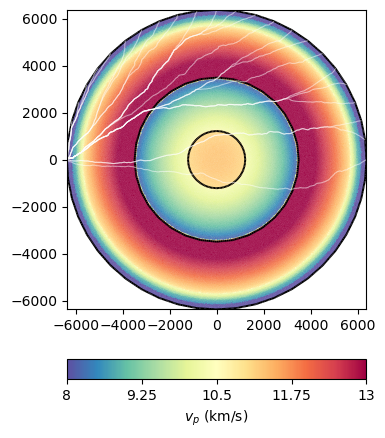

In [ ]:
mgr = tt.Manager(mesh=mesh, data=data, secNodes=7)
rp = mgr.getRayPaths(v)
from matplotlib.collections import LineCollection
ax, _ = pg.show(mesh, v, cMap="Spectral_r", cMin=8, cMax=13, label=r"$v_p$ (km/s)")
lc = LineCollection(rp, color="white", linewidths=0.8, alpha=0.5)
ax.add_collection(lc)

In [ ]:
mgr = tt.Manager(mesh=mesh, data=data, secNodes=5)
modelH = pg.Vector(mesh.cellCount())
rpH = mgr.getRayPaths(modelH, 10)

24/11/23 - 10:29:50 - pyGIMLi - INFO - Creating forward mesh from region infos.
24/11/23 - 10:29:51 - pyGIMLi - INFO - Creating refined mesh (secnodes: 3) to solve forward task.


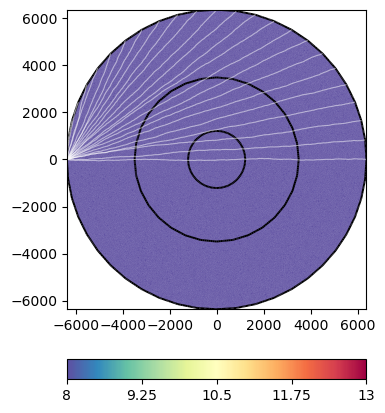

In [ ]:
modelH = pg.Vector(mesh.cellCount())
ax, _ = pg.show(mesh, modelH, cMap="Spectral_r", cMin=8, cMax=13)
lc = LineCollection(rpH, color="white", linewidths=0.8, alpha=0.5)
ax.add_collection(lc)

(<Axes: >, <matplotlib.colorbar.Colorbar at 0x1fe14b4cd60>)

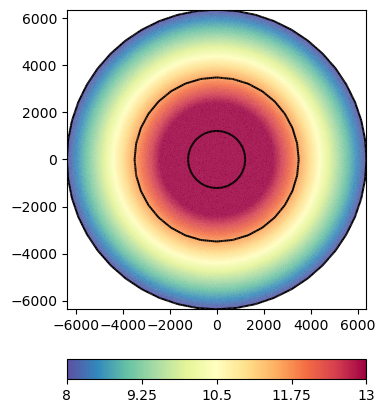

In [ ]:
modelG = np.interp(rn, [0, 6371], [16, 8])
pg.show(mesh, modelG, cMap="Spectral_r", cMin=8, cMax=13)

In [ ]:
tG = fop.response(1/modelG/1000)

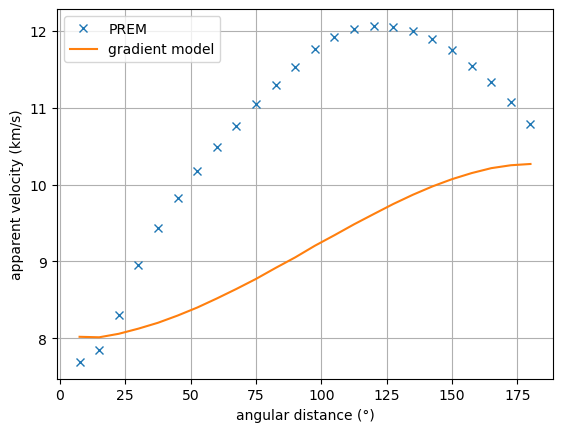

In [ ]:
fig, ax = plt.subplots()
ax.plot(ang, va/1000, "x", label="PREM")
ax.plot(ang, dist/tG/1000, "-", label="gradient model")
ax.set_xlabel("angular distance (°)")
ax.set_ylabel("apparent velocity (km/s)")
ax.grid()
ax.legend()